# Assignment 1

This Jupyter Notebook document is our implementation of Assignment 1. 

Group members:
- Stricescu Razvan Ciprian
- Matteo Belletti
- Alessandro Pasi


# Imports and libraries needed:

In [1]:
# %pip install pandas 
# %pip install numpy
# %pip install matplotlib
# %pip install tqdm
# %pip install seaborn
# %pip install tensorflow
# %pip install keras
# %pip install gensim
# %pip install scikit-learn

import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
import seaborn as sns
import sklearn
import random
import os
from keras.models import Sequential
from keras.layers import Dense, LSTM, Embedding, Bidirectional, TimeDistributed, Dropout
from keras.optimizers import Adam
import pickle
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
import gensim
import gensim.downloader as gloader
from keras.utils import to_categorical
from sklearn.metrics import f1_score
import tensorflow as tf
from sklearn.metrics import confusion_matrix
from collections import Counter


# Task 1: Data Loading and Splitting
* **Download** the corpus.
* **Encode** the corpus into a pandas.DataFrame object.
* **Split** it in training, validation, and test sets.

[Penn TreeBank corpus](https://raw.githubusercontent.com/nltk/nltk_data/gh-pages/packages/corpora/dependency_treebank.zip).

Dataframe generation:

In [2]:
# Create documents dataframe
dp_docs = [file for file in os.listdir('dependency_treebank/') if file.endswith('.dp')]
dataframes = []

for file in tqdm(dp_docs):
    with open('dependency_treebank/' + file, 'r') as f:
        lines = f.readlines()
        data = [line.split('\t') for line in lines]
        df = pd.DataFrame(data, columns=['word', 'pos', 'head'])
        # drop the last column
        df = df.iloc[:, :-1]
        dataframes.append(df)

df = pd.DataFrame({'Dataframes': dataframes})
print(df['Dataframes'][0][0:5])
print(df.shape)

100%|██████████| 199/199 [00:03<00:00, 51.06it/s]

     word  pos
0  Pierre  NNP
1  Vinken  NNP
2       ,    ,
3      61   CD
4   years  NNS
(199, 1)


Data splitting: train, validation, test.

In [3]:
# Split the dataframes into train, validation and test sets
train = df['Dataframes'][0:100]
val = df['Dataframes'][100:150]
test = df['Dataframes'][150:200]

print(f'Train dataframe shape: {train.shape}, Validation dataframe shape: {val.shape}, Test dataframe shape: {test.shape}')

Train dataframe shape: (100,), Validation dataframe shape: (50,), Test dataframe shape: (49,)


Text preprocessing: new line/emtpy line removal.

In [4]:
# Text preprocessing: from each doc remove newlines and empty lines
def remove_newlines(df, docs):
    for i in range(docs, docs + len(df)):
        df[i] = df[i][df[i]['word'] != '\n']
        df[i] = df[i][df[i]['word'] != '']

# Text preprocessing: handle numbers as a single token
def handle_numbers(df, docs):
    for i in range(docs, docs + len(df)):
        df[i]['word'] = df[i]['word'].apply(lambda x: 'NUM' if x.isdigit() else x)

print(f'length of a train sentence before preprocessing: {len(train[0])}\n')
remove_newlines(train, 0)
remove_newlines(val, 100)
remove_newlines(test, 150)
handle_numbers(train, 0)
handle_numbers(val, 100)
handle_numbers(test, 150)
print(train[0][0:5])
print(f'\nLenght of train sentence after preprocessing: {len(train[0])}')

length of a train sentence before preprocessing: 32

     word  pos
0  Pierre  NNP
1  Vinken  NNP
2       ,    ,
3     NUM   CD
4   years  NNS

Lenght of train sentence after preprocessing: 31


We create a sentence list for both normal sentences and tags in order to create the vocabulary.

In [5]:
# Create new list that contains the single sentences
def create_sentences(df, docs):
    sentences = []
    chunks = []
    for i in range(docs, docs + len(df)):
        for element in df[i]['word']:
            if element != '.' and element != '!' and element != '?':
                chunks.append(element)
            else:
                chunks.append(element)
                sentences.append(chunks)
                chunks = []
    return sentences

def create_tag_sentences(df, docs):
    tag_sentences = []
    chunks = []
    for i in range(docs, docs + len(df)):
        for element in df[i]['pos']:
            if element != '.' and element != '!' and element != '?':
                chunks.append(element)
            else:
                chunks.append(element)
                tag_sentences.append(chunks)
                chunks = []
    return tag_sentences

# Create sentences for train, val and test
train_sentences = create_sentences(train, 0)
val_sentences = create_sentences(val, 100)
test_sentences = create_sentences(test, 150)
# Create tag sentences for train, val and test
train_tag_sentences = create_tag_sentences(train, 0)
val_tag_sentences = create_tag_sentences(val, 100)
test_tag_sentences = create_tag_sentences(test, 150)
print(f'Number of train sentences: {len(train_sentences)}, Number of val sentences: {len(val_sentences)}, Number of test sentences: {len(test_sentences)}')
print(f'Number of train tag sentences: {len(train_tag_sentences)}, Number of val tag sentences: {len(val_tag_sentences)}, Number of test tag sentences: {len(test_tag_sentences)}')

Number of train sentences: 1959, Number of val sentences: 1277, Number of test sentences: 638
Number of train tag sentences: 1959, Number of val tag sentences: 1277, Number of test tag sentences: 638


# Task 2: Text encoding

To train a neural POS tagger, you first need to encode text into numerical format.

### Instructions

* Embed words using **GloVe embeddings**.
* You are **free** to pick any embedding dimension.
* [Optional] You are free to experiment with text pre-processing: **make sure you do not delete any token!**

Tokenization: we use the Keras Tokenizer on the training set to create the vocabulary. We then use the GloVe embeddings to create the embedding matrix.

In [6]:
# Encode train sentences and tags using keras tokenizer
sentence_tokenizer = Tokenizer(oov_token='<UNK>') # out of vocabulary token
sentence_tokenizer.fit_on_texts(train_sentences)
encoded_train_sentences = sentence_tokenizer.texts_to_sequences(train_sentences)
encoded_val_sentences = sentence_tokenizer.texts_to_sequences(val_sentences)
encoded_test_sentences = sentence_tokenizer.texts_to_sequences(test_sentences)

print(f'OOV token: {sentence_tokenizer.oov_token}')
print(f'Vocabulary size: {len(sentence_tokenizer.word_index)}')
print(f'Example of an encoded train sentence: {encoded_train_sentences[0]}')

OOV token: <UNK>
Vocabulary size: 7230
Example of an encoded train sentence: [3337, 2243, 2, 10, 66, 336, 2, 42, 1327, 3, 192, 25, 7, 1086, 268, 688, 10, 4]


Testing the tokenization by encoding and decoding a sentence.

In [7]:
# I print and decode sentence 0
i = 2
print(f'Original sentence: {train_sentences[i]}')
print(f'Encoded sentence: {encoded_train_sentences[i]}')
print(f'Decoded sentence: {sentence_tokenizer.sequences_to_texts([encoded_train_sentences[i]])}')

Original sentence: ['Rudolph', 'Agnew', ',', 'NUM', 'years', 'old', 'and', 'former', 'chairman', 'of', 'Consolidated', 'Gold', 'Fields', 'PLC', ',', 'was', 'named', 'a', 'nonexecutive', 'director', 'of', 'this', 'British', 'industrial', 'conglomerate', '.']
Encoded sentence: [1694, 3340, 2, 10, 66, 336, 9, 483, 167, 5, 2244, 1087, 539, 1695, 2, 26, 436, 7, 1086, 268, 5, 47, 1088, 484, 3341, 4]
Decoded sentence: ['rudolph agnew , num years old and former chairman of consolidated gold fields plc , was named a nonexecutive director of this british industrial conglomerate .']


We do the same as above for the tags.

In [8]:
tag_tokenizer = Tokenizer(oov_token='<UNK>')
tag_tokenizer.fit_on_texts(train_tag_sentences)
encoded_train_tags = tag_tokenizer.texts_to_sequences(train_tag_sentences)
encoded_val_tags = tag_tokenizer.texts_to_sequences(val_tag_sentences)
encoded_test_tags = tag_tokenizer.texts_to_sequences(test_tag_sentences)

print(f'Tag vocabulary size: {len(tag_tokenizer.word_index)}')
print(f'Example of an encoded train tag: {encoded_train_tags[0]}')

Tag vocabulary size: 46
Example of an encoded train tag: [3, 3, 8, 12, 6, 7, 8, 21, 13, 5, 2, 4, 5, 7, 2, 3, 12, 9]


Testing the tokenization by encoding and decoding a tag sequence.

In [9]:
print(f'Original tag sentence: {train_tag_sentences[i]}')
print(f'Encoded tag sentence: {encoded_train_tags[i]}')
print(f'Decoded tag sentence: {tag_tokenizer.sequences_to_texts([encoded_train_tags[i]])}')

Original tag sentence: ['NNP', 'NNP', ',', 'CD', 'NNS', 'JJ', 'CC', 'JJ', 'NN', 'IN', 'NNP', 'NNP', 'NNP', 'NNP', ',', 'VBD', 'VBN', 'DT', 'JJ', 'NN', 'IN', 'DT', 'JJ', 'JJ', 'NN', '.']
Encoded tag sentence: [3, 3, 8, 12, 6, 7, 14, 7, 2, 4, 3, 3, 3, 3, 8, 10, 16, 5, 7, 2, 4, 5, 7, 7, 2, 9]
Decoded tag sentence: ['nnp nnp , cd nns jj cc jj nn in nnp nnp nnp nnp , vbd vbn dt jj nn in dt jj jj nn .']


In order to prepare the data for the model we need to pad the sequences to the same length.

First thing we chech the length of the sentences in order to pick a good max length for the padding.

Length of longest sentence: 250


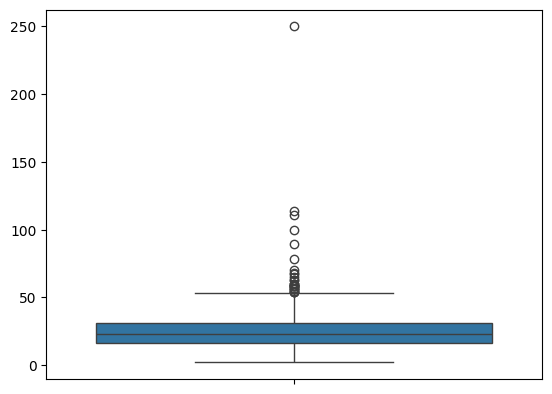

In [10]:
# check length of longest sentence 
lengths = [len(sentence) for sentence in encoded_train_sentences]
print(f'Length of longest sentence: {max(lengths)}')
sns.boxplot(lengths)
plt.show()

Text padding: we use the Keras pad_sequences function to pad the sentences to the same length. We chose a max length of 100 as most of the sentences are shorter than that.

We pad both the sentences and the tags.

In [11]:
# Pad each sequence to MAX_SEQ_LENGTH using KERAS' pad_sequences() function. 
# Sentences longer than MAX_SEQ_LENGTH are truncated.
# Sentences shorter than MAX_SEQ_LENGTH are padded with zeroes.

# Truncation and padding can either be 'pre' or 'post'. 
# For padding we are using 'pre' padding type, that is, add zeroes on the left side.
# For truncation, we are using 'post', that is, truncate a sentence from right side.

MAX_SEQ_LENGTH = 100
train_padded = pad_sequences(encoded_train_sentences, maxlen=MAX_SEQ_LENGTH, padding='pre', truncating='post')
train_tag_padded = pad_sequences(encoded_train_tags, maxlen=MAX_SEQ_LENGTH, padding='pre', truncating='post')
val_padded = pad_sequences(encoded_val_sentences, maxlen=MAX_SEQ_LENGTH, padding='pre', truncating='post')
val_tag_padded = pad_sequences(encoded_val_tags, maxlen=MAX_SEQ_LENGTH, padding='pre', truncating='post')
test_padded = pad_sequences(encoded_test_sentences, maxlen=MAX_SEQ_LENGTH, padding='pre', truncating='post')
test_tag_padded = pad_sequences(encoded_test_tags, maxlen=MAX_SEQ_LENGTH, padding='pre', truncating='post')

print(f'Example of a padded train sentence:\n{train_padded[0]}')

Example of a padded train sentence:
[   0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0 3337 2243
    2   10   66  336    2   42 1327    3  192   25    7 1086  268  688
   10    4]


Now that the data is both encoded and padded we can import the GloVe embeddings and create the embedding matrix.

In [12]:
def load_embedding_model(embedding_dimension: int = 50) -> gensim.models.keyedvectors.KeyedVectors:
    download_path = ""
    download_path = "glove-wiki-gigaword-{}".format(embedding_dimension)
        
    try:
        emb_model = gloader.load(download_path)
    except ValueError as e:
        print("Invalid embedding model name! Check the embedding dimension:")
        print("Glove: 50, 100, 200, 300")
        raise e

    return emb_model

# Glove -> 50, 100, 200, 300
embedding_model = load_embedding_model(embedding_dimension=50)

We create the embedding matrix by importing the GloVe embeddings and using the vocabulary created by the Tokenizer.

Preferably if the GloVe embedding exists for a word we use that, otherwise we use a random embedding.

In [13]:
def create_embedding_matrix(embedding_model, word2id, embedding_dim):
    vocab_size = len(word2id) + 1
    embedding_matrix = np.zeros((vocab_size, embedding_dim))
    OOV_embedding = np.random.rand(embedding_dim)
    count_not_in_glove = 0
    for word, i in tqdm(word2id.items()):
        try:
            embedding_matrix[i, :] = embedding_model[word]
        except KeyError:
            if word == '<UNK>':
                # give <UNK> a static embedding
                embedding_matrix[i, :] = OOV_embedding
                continue
            # If the word is not in the embedding model, it will have a random embedding vector, but check that its not already present
            embedding_vector = np.random.rand(embedding_dim)
            while embedding_vector in embedding_matrix:
                embedding_vector = np.random.rand(embedding_dim)
            embedding_matrix[i, :] = embedding_vector
            count_not_in_glove += 1
    print(f'Number of words that have no glove embedding: {count_not_in_glove}')
    return embedding_matrix

embedding_dim = 50
embedding_train_matrix = create_embedding_matrix(embedding_model, sentence_tokenizer.word_index, embedding_dim)
print(f'Embedding matrix shape: {embedding_train_matrix.shape}')

100%|██████████| 7230/7230 [00:00<00:00, 73756.09it/s]

Number of words that have no glove embedding: 358
Embedding matrix shape: (7231, 50)


For the tags we one-hot encode them using the Keras to_categorical function.

In [14]:
# For tags use one-hot encoding
Y_train = to_categorical(train_tag_padded)
print(f'One-hot encoded train tag shape: {Y_train.shape}')
print(f'Example of a one-hot encoded train tag:\n{Y_train[0][0]}')

One-hot encoded train tag shape: (1959, 100, 47)
Example of a one-hot encoded train tag:
[1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]


Here we reassing the training, validation and test sets which are now encoded and padded, ready to be fed to the model.

In [15]:
# Split the data into train, val and test sets
X_train = train_padded
X_val = val_padded
Y_val = to_categorical(val_tag_padded)
X_test = test_padded
Y_test = to_categorical(test_tag_padded, num_classes=len(tag_tokenizer.word_index)+1) # for test also consider the missing tags
print(f'X_train shape: {X_train.shape}, Y_train shape: {Y_train.shape}')
print(f'X_val shape: {X_val.shape}, Y_val shape: {Y_val.shape}')
print(f'X_test shape: {X_test.shape}, Y_test shape: {Y_test.shape}')

X_train shape: (1959, 100), Y_train shape: (1959, 100, 47)
X_val shape: (1277, 100), Y_val shape: (1277, 100, 47)
X_test shape: (638, 100), Y_test shape: (638, 100, 47)


We check for OOV words in the sets, as we can see for the training set there are 0 OOV words because it constitutes the vocabulary.

In [16]:
def check_OOV_terms(X):
    count_OOV = 0
    for sentence in X:
        for word in sentence:
            if word == 1:
                count_OOV += 1
    return count_OOV

print(f'Number of OOV terms in train set: {check_OOV_terms(X_train)}')
print(f'Number of OOV terms in val set: {check_OOV_terms(X_val)}')
print(f'Number of OOV terms in test set: {check_OOV_terms(X_test)}')

Number of OOV terms in train set: 0
Number of OOV terms in val set: 3639
Number of OOV terms in test set: 1929


# Task 3: Model definition

You are now tasked to define your neural POS tagger.

### Instructions

* **Baseline**: implement a Bidirectional LSTM with a Dense layer on top.
* You are **free** to experiment with hyper-parameters to define the baseline model.

* **Model 1**: add an additional LSTM layer to the Baseline model.
* **Model 2**: add an additional Dense layer to the Baseline model.

* **Do not mix Model 1 and Model 2**. Each model has its own instructions.

**Note**: if a document contains many tokens, you are **free** to split them into chunks or sentences to define your mini-batches.

We define three different seeds for the models in order to have reproducible results.

In [17]:
# Number of tags is the tag vocabulary, it is the number of classes we want to predict 
num_tags = Y_train.shape[2]

# Seed definition
#seed = 42
#seed = 69
seed = 420

# Set the seed for numpy and tensorflow
np.random.seed(seed)
tf.random.set_seed(seed)

### Baseline model definition:





For the baseline model we use a Bidirectional LSTM with a Dense layer. Hyperparameters are chosen by using a grid search. 

We left the hyperparameters in the code but commented out as they take a long time to run. We will just load the best ones we found for further tasks.

In [18]:
# Baseline model: LSTM + FC

#HYPERPARAMETERS TUNING:

def create_baseline_model(lstm_units, dropout_rate, recurrent_dropout_rate, learning_rate):
    model = Sequential()
    model.add(Embedding(input_dim=len(sentence_tokenizer.word_index)+1, output_dim=embedding_dim, input_length=MAX_SEQ_LENGTH, weights=[embedding_train_matrix], trainable=True, mask_zero=True))
    model.add(Bidirectional(LSTM(units=lstm_units, return_sequences=True, dropout=dropout_rate, recurrent_dropout=recurrent_dropout_rate)))
    model.add(TimeDistributed(Dense(num_tags, activation='softmax')))
    model.compile(loss='categorical_crossentropy', optimizer=Adam(learning_rate=learning_rate), metrics=['accuracy'])
    return model
'''
hyperparameters = { 'lstm_units': [128, 256], 
                    'dropout_rate': [0.1, 0.2, 0.3],
                    'recurrent_dropout_rate': [0.1, 0.2, 0.3],
                    'learning_rate': [0.001, 0.01],
                    'batch_size': [32, 64, 128]
                  }
# for each hyperparameter combination, train the model for 3 epochs and save the model with the best validation accuracy
from sklearn.model_selection import ParameterGrid

# create a list of all possible combinations of hyperparameters
param_grid = ParameterGrid(hyperparameters)
print(f'Number of hyperparameter combinations: {len(param_grid)}')

# train the model for each hyperparameter combination
from sklearn.metrics import accuracy_score

best_baseline_val_accuracy = 0
best_baseline_model = None
best_baseline_hyperparameters = None

for params in tqdm(param_grid):
    model = create_baseline_model(params['lstm_units'], params['dropout_rate'], params['recurrent_dropout_rate'], params['learning_rate'])
    model.fit(X_train, Y_train, epochs=1, batch_size=params['batch_size'], verbose=0)
    val_loss, val_accuracy = model.evaluate(X_val, Y_val, verbose=0)
    if val_accuracy > best_baseline_val_accuracy:
        best_baseline_val_accuracy = val_accuracy
        best_baseline_model = model
        best_baseline_hyperparameters = params

print(f'Best validation accuracy: {best_baseline_val_accuracy}')
print(f'Best hyperparameters: {best_baseline_hyperparameters}') 

# save the hyperparameters and the model
import pickle
with open('best_baseline_hyperparameters.pickle', 'wb') as f:
    pickle.dump(best_baseline_hyperparameters, f)
best_baseline_model.save('best_baseline_model.h5')
'''

"\nhyperparameters = { 'lstm_units': [128, 256], \n                    'dropout_rate': [0.1, 0.2, 0.3],\n                    'recurrent_dropout_rate': [0.1, 0.2, 0.3],\n                    'learning_rate': [0.001, 0.01],\n                    'batch_size': [32, 64, 128]\n                  }\n# for each hyperparameter combination, train the model for 3 epochs and save the model with the best validation accuracy\nfrom sklearn.model_selection import ParameterGrid\n\n# create a list of all possible combinations of hyperparameters\nparam_grid = ParameterGrid(hyperparameters)\nprint(f'Number of hyperparameter combinations: {len(param_grid)}')\n\n# train the model for each hyperparameter combination\nfrom sklearn.metrics import accuracy_score\n\nbest_baseline_val_accuracy = 0\nbest_baseline_model = None\nbest_baseline_hyperparameters = None\n\nfor params in tqdm(param_grid):\n    model = create_baseline_model(params['lstm_units'], params['dropout_rate'], params['recurrent_dropout_rate'], param

Here we load the best hyperparameters and create the model.

In [19]:
# load the model
best_baseline_hyperparameters = pickle.load(open('assignement1_hyperparams/best_baseline_hyperparameters.pickle', 'rb'))
baseline = create_baseline_model(best_baseline_hyperparameters['lstm_units'], best_baseline_hyperparameters['dropout_rate'], best_baseline_hyperparameters['recurrent_dropout_rate'], best_baseline_hyperparameters['learning_rate'])
baseline.summary()


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 100, 50)           361550    
                                                                 
 bidirectional (Bidirection  (None, 100, 512)          628736    
 al)                                                             
                                                                 
 time_distributed (TimeDist  (None, 100, 47)           24111     
 ributed)                                                        
                                                                 
Total params: 1014397 (3.87 MB)
Trainable params: 1014397 (3.87 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


### Model 1 model definition:

Model 1 is the baseline model with an additional LSTM layer. Hyperparameters are chosen by using a grid search.

We chose to not show the commented out for grid search as it is very similar to the one used for the baseline model with some additional parameters. Like before we will just load the best ones we found for further tasks.

In [20]:
# Model 1: LSTM + LSTM + FC

#HYPERPARAMETERS TUNING:

def create_model1(lstm_units, dropout_rate, recurrent_dropout_rate, learning_rate):
    model = Sequential()
    model.add(Embedding(input_dim=len(sentence_tokenizer.word_index) + 1, output_dim=embedding_dim, input_length=MAX_SEQ_LENGTH, weights=[embedding_train_matrix], trainable=True, mask_zero=True))
    model.add(Bidirectional(LSTM(units=lstm_units, return_sequences=True, dropout=dropout_rate, recurrent_dropout=recurrent_dropout_rate)))
    model.add(Bidirectional(LSTM(units=int(lstm_units/2), return_sequences=True, dropout=dropout_rate, recurrent_dropout=recurrent_dropout_rate)))
    model.add(TimeDistributed(Dense(num_tags, activation='softmax')))
    model.compile(loss='categorical_crossentropy', optimizer=Adam(learning_rate=learning_rate), metrics=['accuracy'])
    return model

In [21]:
# load the model
best_model1_hyperparameters = pickle.load(open('assignement1_hyperparams/best_model1_hyperparameters.pickle', 'rb'))
model1 = create_model1(best_model1_hyperparameters['lstm_units'], best_model1_hyperparameters['dropout_rate'], best_model1_hyperparameters['recurrent_dropout_rate'], best_model1_hyperparameters['learning_rate'])
model1.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_1 (Embedding)     (None, 100, 50)           361550    
                                                                 
 bidirectional_1 (Bidirecti  (None, 100, 512)          628736    
 onal)                                                           
                                                                 
 bidirectional_2 (Bidirecti  (None, 100, 256)          656384    
 onal)                                                           
                                                                 
 time_distributed_1 (TimeDi  (None, 100, 47)           12079     
 stributed)                                                      
                                                                 
Total params: 1658749 (6.33 MB)
Trainable params: 1658749 (6.33 MB)
Non-trainable params: 0 (0.00 Byte)
________________

### Model 2 model definition:

Model 2 is the baseline model with an additional Dense layer. Hyperparameters are chosen by using a grid search.

We chose to not show the commented out for grid search as it is very similar to the one used for the baseline model with some additional parameters. Like before we will just load the best ones we found for further tasks.

In [22]:
# Model 2: LSTM + FC + FC

#HYPERPARAMETERS TUNING:

def create_model2(lstm_units, dropout_rate, recurrent_dropout_rate, learning_rate):
    model = Sequential()
    model.add(Embedding(input_dim=len(sentence_tokenizer.word_index) + 1, output_dim=embedding_dim, input_length=MAX_SEQ_LENGTH, weights=[embedding_train_matrix], trainable=True, mask_zero=True))
    model.add(Bidirectional(LSTM(units=lstm_units, return_sequences=True, dropout=dropout_rate, recurrent_dropout=recurrent_dropout_rate)))
    model.add(TimeDistributed(Dense(num_tags*2, activation="softmax")))
    model.add(TimeDistributed(Dense(num_tags, activation="softmax")))
    model.compile(loss='categorical_crossentropy', optimizer=Adam(learning_rate=learning_rate), metrics=['accuracy'])
    return model

In [23]:
# load the model
best_model2_hyperparameters = pickle.load(open('assignement1_hyperparams/best_model2_hyperparameters.pickle', 'rb'))
model2 = create_model2(best_model2_hyperparameters['lstm_units'], best_model2_hyperparameters['dropout_rate'], best_model2_hyperparameters['recurrent_dropout_rate'], best_model2_hyperparameters['learning_rate'])
model2.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_2 (Embedding)     (None, 100, 50)           361550    
                                                                 
 bidirectional_3 (Bidirecti  (None, 100, 256)          183296    
 onal)                                                           
                                                                 
 time_distributed_2 (TimeDi  (None, 100, 94)           24158     
 stributed)                                                      
                                                                 
 time_distributed_3 (TimeDi  (None, 100, 47)           4465      
 stributed)                                                      
                                                                 
Total params: 573469 (2.19 MB)
Trainable params: 573469 (2.19 MB)
Non-trainable params: 0 (0.00 Byte)
__________________

# Task 4: Metrics

Before training the models, you are tasked to define the evaluation metrics for comparison.

### Instructions

* Evaluate your models using macro F1-score, compute over **all** tokens.
* **Concatenate** all tokens in a data split to compute the F1-score. (**Hint**: accumulate FP, TP, FN, TN iteratively) 
* **Do not consider punctuation and symbol classes** $\rightarrow$ [What is punctuation?](https://en.wikipedia.org/wiki/English_punctuation)

**Note**: What about OOV tokens?
   * All the tokens in the **training** set that are not in GloVe are **not** considered as OOV
   * For the remaining tokens (i.e., OOV in the validation and test sets), you have to assign them a **static** embedding.
   * You are **free** to define the static embedding using any strategy (e.g., random, neighbourhood, 

We define the tag_to_index dictionary which will be used to compute the F1-score.

In [24]:
tag2idx = tag_tokenizer.word_index
idx2tag = {i: w for w, i in tag2idx.items()}
print(f'Tag to index dictionary:\n{tag2idx}')

Tag to index dictionary:
{'<UNK>': 1, 'nn': 2, 'nnp': 3, 'in': 4, 'dt': 5, 'nns': 6, 'jj': 7, ',': 8, '.': 9, 'vbd': 10, 'rb': 11, 'cd': 12, 'vb': 13, 'cc': 14, 'vbz': 15, 'vbn': 16, 'to': 17, 'prp': 18, 'vbg': 19, 'vbp': 20, 'md': 21, 'prp$': 22, '``': 23, 'pos': 24, "''": 25, '$': 26, ':': 27, 'wdt': 28, 'jjr': 29, 'wp': 30, 'rp': 31, 'nnps': 32, 'jjs': 33, 'wrb': 34, 'rbr': 35, '-rrb-': 36, '-lrb-': 37, 'ex': 38, 'rbs': 39, 'ls': 40, 'pdt': 41, 'wp$': 42, 'fw': 43, 'uh': 44, 'sym': 45, '#': 46}


During metric computation we ignore the padding, OOV and punctuation tags.

In [25]:
# print index of punctuation marks (. , ? ! " ' - : ; )
punctuation_tags = [',', '.', '?', '!', '"', "'", '-', ':', ';' , '<UNK>', '(', ')', '[', ']', '{', '}', '<', '>']
punctuation_tags_idx = []
for tag in punctuation_tags:
    try:
        punctuation_tags_idx.append(tag2idx[tag])
    except KeyError:
        continue

print(f'Index of punctuation tags: {punctuation_tags_idx}')
print(f'Tag of punctuation tags: {[idx2tag[i] for i in punctuation_tags_idx]}')

Index of punctuation tags: [8, 9, 27, 1]
Tag of punctuation tags: [',', '.', ':', '<UNK>']


Here we define the F1-score function which will be used as a metric for the models.

In [26]:
# Metrics: Macro F1 score over all tokens, do not consider punctuation

def macro_f1(y_true, y_pred):
    # get the index of the highest probability for each token
    y_true = np.argmax(y_true, axis=-1)
    y_pred = np.argmax(y_pred, axis=-1)
    # flatten the arrays
    y_true = y_true.flatten()
    y_pred = y_pred.flatten()
    temp = [] 
    temp_pred = []
    # remove punctuation tags from y_true
    for i in range(len(y_true)):
        if y_true[i] not in punctuation_tags_idx and y_true[i] != 0:
            temp.append(y_true[i])
            temp_pred.append(y_pred[i])
    return f1_score(temp, temp_pred, average='macro')         

Here we define the average performance function which will be computed on all the seeds. It also computes the standard deviation.

In [27]:
def evaluate_model(model_name, X, Y):
    seeds = [42, 69, 420]
    macro_f1_scores = []
    for seed_ in seeds:
        model = tf.keras.models.load_model(f'seed_{seed_}/{model_name}_{seed_}.h5')
        np.random.seed(seed_)
        tf.random.set_seed(seed_)
        Y_pred = model.predict(X)
        macro_f1_scores.append(macro_f1(Y, Y_pred))
        print(f'Seed: {seed_}, Macro F1 score: {macro_f1_scores[-1]}')
        # compute standard deviation of macro f1 scores
    return np.mean(macro_f1_scores), np.std(macro_f1_scores)

# Task 5: Training and Evaluation

You are now tasked to train and evaluate the Baseline, Model 1, and Model 2.

### For just evaluation skip to the next section as we load the best models we found.

### Instructions

* Train **all** models on the train set.
* Evaluate **all** models on the validation set.
* Compute metrics on the validation set.
* Pick **at least** three seeds for robust estimation.
* Pick the **best** performing model according to the observed validation set performance.

### Baseline model training:





In [28]:
history_baseline = baseline.fit(X_train, Y_train, validation_data=(X_val, Y_val), batch_size=best_baseline_hyperparameters["batch_size"], epochs=20, verbose=1)

Epoch 1/20


62/62 [==============================] - 39s 507ms/step - loss: 1.0703 - accuracy: 0.7177 - val_loss: 0.5008 - val_accuracy: 0.8559
Epoch 2/20
62/62 [==============================] - 31s 495ms/step - loss: 0.2227 - accuracy: 0.9348 - val_loss: 0.3916 - val_accuracy: 0.8836
Epoch 3/20
62/62 [==============================] - 29s 461ms/step - loss: 0.1095 - accuracy: 0.9678 - val_loss: 0.3641 - val_accuracy: 0.8923
Epoch 4/20
62/62 [==============================] - 28s 454ms/step - loss: 0.0644 - accuracy: 0.9808 - val_loss: 0.4069 - val_accuracy: 0.8899
Epoch 5/20
62/62 [==============================] - 29s 476ms/step - loss: 0.0377 - accuracy: 0.9888 - val_loss: 0.4100 - val_accuracy: 0.8929
Epoch 6/20
62/62 [==============================] - 28s 454ms/step - loss: 0.0265 - accuracy: 0.9924 - val_loss: 0.4706 - val_accuracy: 0.8889
Epoch 7/20
62/62 [==============================] - 29s 477ms/step - loss: 0.0219 - accuracy: 0.9936 - val_loss: 0.4684 - val_accuracy: 0.89

After training the model we plot the training and validation loss and accuracy.

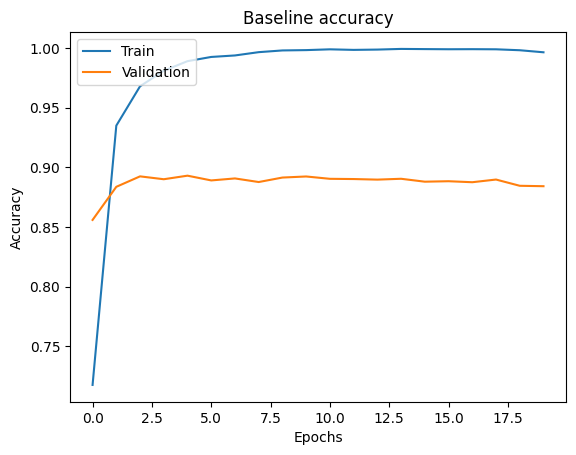

In [29]:
# plot results
plt.plot(history_baseline.history['accuracy'])
plt.plot(history_baseline.history['val_accuracy'])
plt.title('Baseline accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epochs')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

As we can see the model is overfitting as the validation accuracy is lower than the training accuracy which keeps increasing.

The same happens for the loss, the validation loss is higher than the training loss which keeps decreasing.

We save the model in order to experiment with different seeds.

In [30]:
# save the model
baseline.save(f'seed_{seed}/baseline_{seed}.h5')

d:\NLProject\.venv\lib\site-packages\keras\src\engine\training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


### Base model evaluation on current seed:

In [31]:
# Evaluate the models
print("Baseline model")
print("Train accuracy: {}".format(baseline.evaluate(X_train, Y_train)[1]))
print("Validation accuracy: {}".format(baseline.evaluate(X_val, Y_val)[1]))
print("Test accuracy: {}".format(baseline.evaluate(X_test, Y_test)[1]))
print("Macro F1 score: {}".format(macro_f1(Y_test, baseline.predict(X_test))))

Baseline model
62/62 [==============================] - 4s 66ms/step - loss: 0.0067 - accuracy: 0.9982
Train accuracy: 0.9981772303581238
40/40 [==============================] - 3s 66ms/step - loss: 0.5914 - accuracy: 0.8841
Validation accuracy: 0.884103536605835
20/20 [==============================] - 1s 66ms/step - loss: 0.5385 - accuracy: 0.8878
Test accuracy: 0.8878095746040344
20/20 [==============================] - 2s 65ms/step
Macro F1 score: 0.7861034533067424


### Model 1 training:

In [31]:
history_model1 = model1.fit(X_train, Y_train, validation_data=(X_val, Y_val), batch_size=best_model1_hyperparameters["batch_size"], epochs=20, verbose=1)

Epoch 1/20
62/62 [==============================] - 83s 1s/step - loss: 1.3892 - accuracy: 0.6161 - val_loss: 0.6322 - val_accuracy: 0.8282
Epoch 2/20
62/62 [==============================] - 66s 1s/step - loss: 0.2703 - accuracy: 0.9220 - val_loss: 0.4838 - val_accuracy: 0.8664
Epoch 3/20
62/62 [==============================] - 70s 1s/step - loss: 0.1345 - accuracy: 0.9613 - val_loss: 0.4991 - val_accuracy: 0.8712
Epoch 4/20
62/62 [==============================] - 72s 1s/step - loss: 0.0801 - accuracy: 0.9768 - val_loss: 0.5109 - val_accuracy: 0.8743
Epoch 5/20
62/62 [==============================] - 72s 1s/step - loss: 0.0580 - accuracy: 0.9815 - val_loss: 0.5895 - val_accuracy: 0.8723
Epoch 6/20
62/62 [==============================] - 73s 1s/step - loss: 0.0400 - accuracy: 0.9876 - val_loss: 0.6440 - val_accuracy: 0.8651
Epoch 7/20
62/62 [==============================] - 72s 1s/step - loss: 0.0283 - accuracy: 0.9912 - val_loss: 0.6757 - val_accuracy: 0.8671
Epoch 8/20
62/62 [==

We plot the training and validation loss and accuracy.

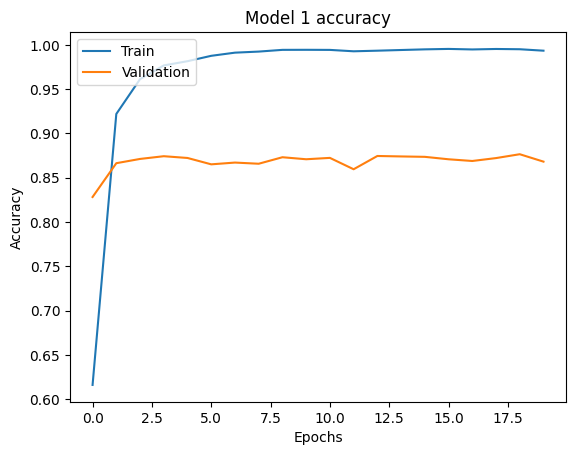

In [32]:
# plot results
plt.plot(history_model1.history['accuracy'])
plt.plot(history_model1.history['val_accuracy'])
plt.title('Model 1 accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epochs')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

Like before the model is overfitting as the validation accuracy is lower than the training accuracy which keeps increasing.

We save the model in order to experiment with different seeds.

In [33]:
# save the model
model1.save(f'seed_{seed}/model1_{seed}.h5')

d:\NLProject\.venv\lib\site-packages\keras\src\engine\training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


### Model 1 evaluation on current seed:

In [34]:
# Evaluate the models
print("Model 1")
print("Train accuracy: {}".format(model1.evaluate(X_train, Y_train)[1]))
print("Validation accuracy: {}".format(model1.evaluate(X_val, Y_val)[1]))
print("Test accuracy: {}".format(model1.evaluate(X_test, Y_test)[1]))
print("Macro F1 score: {}".format(macro_f1(Y_test, model1.predict(X_test))))

Model 1
62/62 [==============================] - 11s 169ms/step - loss: 0.0083 - accuracy: 0.9977
Train accuracy: 0.9976897239685059
40/40 [==============================] - 7s 166ms/step - loss: 0.8581 - accuracy: 0.8682
Validation accuracy: 0.8681653738021851
20/20 [==============================] - 3s 163ms/step - loss: 0.8338 - accuracy: 0.8692
Test accuracy: 0.8692184090614319
20/20 [==============================] - 4s 164ms/step
Macro F1 score: 0.7331911994943942


### Model 2 training:

In [59]:
history_model2 = model2.fit(X_train, Y_train, validation_data=(X_val, Y_val), batch_size=best_model2_hyperparameters["batch_size"], epochs=50, verbose=1)

Epoch 1/50
62/62 [==============================] - 22s 246ms/step - loss: 3.2122 - accuracy: 0.2639 - val_loss: 2.6889 - val_accuracy: 0.3112
Epoch 2/50
62/62 [==============================] - 13s 210ms/step - loss: 2.3550 - accuracy: 0.3497 - val_loss: 2.2009 - val_accuracy: 0.3645
Epoch 3/50
62/62 [==============================] - 13s 212ms/step - loss: 1.9770 - accuracy: 0.3634 - val_loss: 1.9857 - val_accuracy: 0.3293
Epoch 4/50
62/62 [==============================] - 13s 209ms/step - loss: 1.8111 - accuracy: 0.3709 - val_loss: 1.9242 - val_accuracy: 0.3264
Epoch 5/50
62/62 [==============================] - 13s 203ms/step - loss: 1.7279 - accuracy: 0.3788 - val_loss: 1.8884 - val_accuracy: 0.3431
Epoch 6/50
62/62 [==============================] - 13s 209ms/step - loss: 1.6593 - accuracy: 0.4248 - val_loss: 1.7890 - val_accuracy: 0.4296
Epoch 7/50
62/62 [==============================] - 13s 206ms/step - loss: 1.5472 - accuracy: 0.4870 - val_loss: 1.6601 - val_accuracy: 0.4455

We plot the training and validation loss and accuracy.

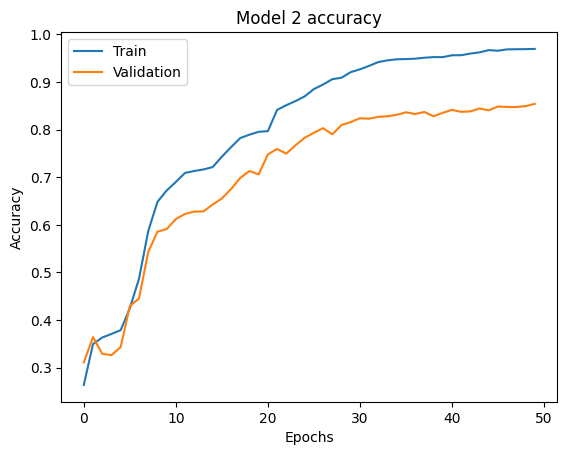

In [60]:
# plot results
plt.plot(history_model2.history['accuracy'])
plt.plot(history_model2.history['val_accuracy'])
plt.title('Model 2 accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epochs')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

Here the model is not overfitting as quickly as the previous models but it still reaches a point where the validation accuracy is lower than the training accuracy which keeps increasing while the validation accuracy remains constant.

we save the model in order to experiment with different seeds.

In [61]:
# save the model
model2.save(f'seed_{seed}/model2_{seed}.h5')

d:\NLProject\.venv\lib\site-packages\keras\src\engine\training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


### Model 2 evaluation on current seed:

In [62]:
# Evaluate the models
print("Model 2")
print("Train accuracy: {}".format(model2.evaluate(X_train, Y_train)[1]))
print("Validation accuracy: {}".format(model2.evaluate(X_val, Y_val)[1]))
print("Test accuracy: {}".format(model2.evaluate(X_test, Y_test)[1]))
print("Macro F1 score: {}".format(macro_f1(Y_test, model2.predict(X_test))))

Model 2
62/62 [==============================] - 3s 41ms/step - loss: 0.1670 - accuracy: 0.9739
Train accuracy: 0.9738665819168091
40/40 [==============================] - 2s 41ms/step - loss: 0.9356 - accuracy: 0.8542
Validation accuracy: 0.8541513085365295
20/20 [==============================] - 1s 41ms/step - loss: 0.9301 - accuracy: 0.8577
Test accuracy: 0.857703447341919
20/20 [==============================] - 1s 43ms/step
Macro F1 score: 0.6603790430676929


### Average performance of the models:

Baseline model average performance:

In [63]:
average_macro_f1_baseline, std_macro_f1_baseline = evaluate_model('baseline', X_test, Y_test)
print(f'Baseline average macro f1 score: {average_macro_f1_baseline}, Baseline std macro f1 score: {std_macro_f1_baseline}')

20/20 [==============================] - 3s 111ms/step
Seed: 42, Macro F1 score: 0.8027820580975323
20/20 [==============================] - 3s 110ms/step
Seed: 69, Macro F1 score: 0.7415175796669692
20/20 [==============================] - 3s 107ms/step
Seed: 420, Macro F1 score: 0.7987517058971952
Baseline average macro f1 score: 0.781017114553899, Baseline std macro f1 score: 0.02797881194675148


Model 1 average performance:

In [64]:
average_macro_f1_model1, std_macro_f1_model1 = evaluate_model('model1', X_test, Y_test)
print(f'Model 1 average macro f1 score: {average_macro_f1_model1}, Model 1 std macro f1 score: {std_macro_f1_model1}')

20/20 [==============================] - 5s 182ms/step
Seed: 42, Macro F1 score: 0.7331911994943942
20/20 [==============================] - 4s 166ms/step
Seed: 69, Macro F1 score: 0.812258226782635
20/20 [==============================] - 4s 160ms/step
Seed: 420, Macro F1 score: 0.8476262363669371
Model 1 average macro f1 score: 0.7976918875479888, Model 1 std macro f1 score: 0.04783985852145443


Model 2 average performance:

In [65]:
average_macro_f1_model2, std_macro_f1_model2 = evaluate_model('model2', X_test, Y_test)
print(f'Model 2 average macro f1 score: {average_macro_f1_model2}, Model 2 std macro f1 score: {std_macro_f1_model2}')

20/20 [==============================] - 1s 41ms/step
Seed: 42, Macro F1 score: 0.6603790430676929
20/20 [==============================] - 1s 38ms/step
Seed: 69, Macro F1 score: 0.5447243107386692
20/20 [==============================] - 1s 38ms/step
Seed: 420, Macro F1 score: 0.6499215148634261
Model 2 average macro f1 score: 0.6183416228899294, Model 2 std macro f1 score: 0.052230077288332746


Model 1 has the best performance on the validation set so we will use it for further tasks. Model 2 has the worst performance overall but we saw that if we train it for more epochs it can achieve better results, so we decided to train for 50 epochs instead of 20 even though it is not consistent with the other models.

Model 2 seems to be the most unstable model as it has the highest standard deviation and the worst performance on the validation set. This is due to the structure of the model which adds an additional Dense layer, rather than a second LSTM, on top of the LSTM layer capturing less sequential dependencies in data.

# Task 6: Error Analysis

You are tasked to evaluate your best performing model.

### Instructions

* Compare the errors made on the validation and test sets.
* Aggregate model errors into categories (if possible) 
* Comment the about errors and propose possible solutions on how to address them.

We load the best models which we found to be with seed 42. All other models and their results are present in the respective seed folders and can be loaded by changing the seed number in task 3.

In [32]:
baseline = tf.keras.models.load_model(f'seed_{seed}/baseline_{seed}.h5')
model1 = tf.keras.models.load_model(f'seed_{seed}/model1_{seed}.h5')    
model2 = tf.keras.models.load_model(f'seed_{seed}/model2_{seed}.h5')

We define a function to compute the F1-score for each tag.

In [33]:
def score_per_tag(y_true, y_pred):
    scores = {}
    y_true = np.argmax(y_true, axis=-1)
    y_pred = np.argmax(y_pred, axis=-1)
    y_true = y_true.flatten()
    y_pred = y_pred.flatten()
    temp = [] 
    temp_pred = []
    for i in range(len(y_true)):
        if y_true[i] not in punctuation_tags_idx and y_true[i] != 0: # if the tag is not a punctuation tag
            temp.append(y_true[i])
            temp_pred.append(y_pred[i])
    tag_true = []
    tag_pred = []
    for el in tag2idx.keys():
        tag_true = []
        tag_pred = []
        for i in range(len(temp)):
            if temp[i] == tag2idx.get(el) and tag2idx.get(el) not in punctuation_tags_idx: # if the tag is not a punctuation tag
                tag_true.append(temp[i])
                tag_pred.append(temp_pred[i])
        if len(tag_pred) != 0 and len(tag_true) != 0:
            scores[el] = f1_score(tag_true, tag_pred, average='macro')
    return scores

This function is purely cosmetic and is used to plot the results in a nicer way.

In [34]:
def set_color(number_of_colors):
    # return a random color to be used for the plot
    color_list = []
    for i in range(number_of_colors):
        color_list.append("#"+''.join([random.choice('0123456789ABCDEF') for j in range(6)]))
    return color_list

We comupute for each tag the F1-score but in order to plot it we need to get their tag names. We don't consider tags which have a score of 1 as we are interested only in the errors.

In [35]:
def get_scores_tag(scores):
    # return a list of scores and a list of tags
    scores_tags =  {tag2idx[key]: value for key, value in scores.items()}
    scores_tags = {key: value for key, value in scores_tags.items() if value < 1.0}
    scores_tags =  {idx2tag[key]: value for key, value in scores_tags.items()}
    return scores_tags

Here we define the different plots for test and validation sets.

40/40 [==============================] - 1s 29ms/step


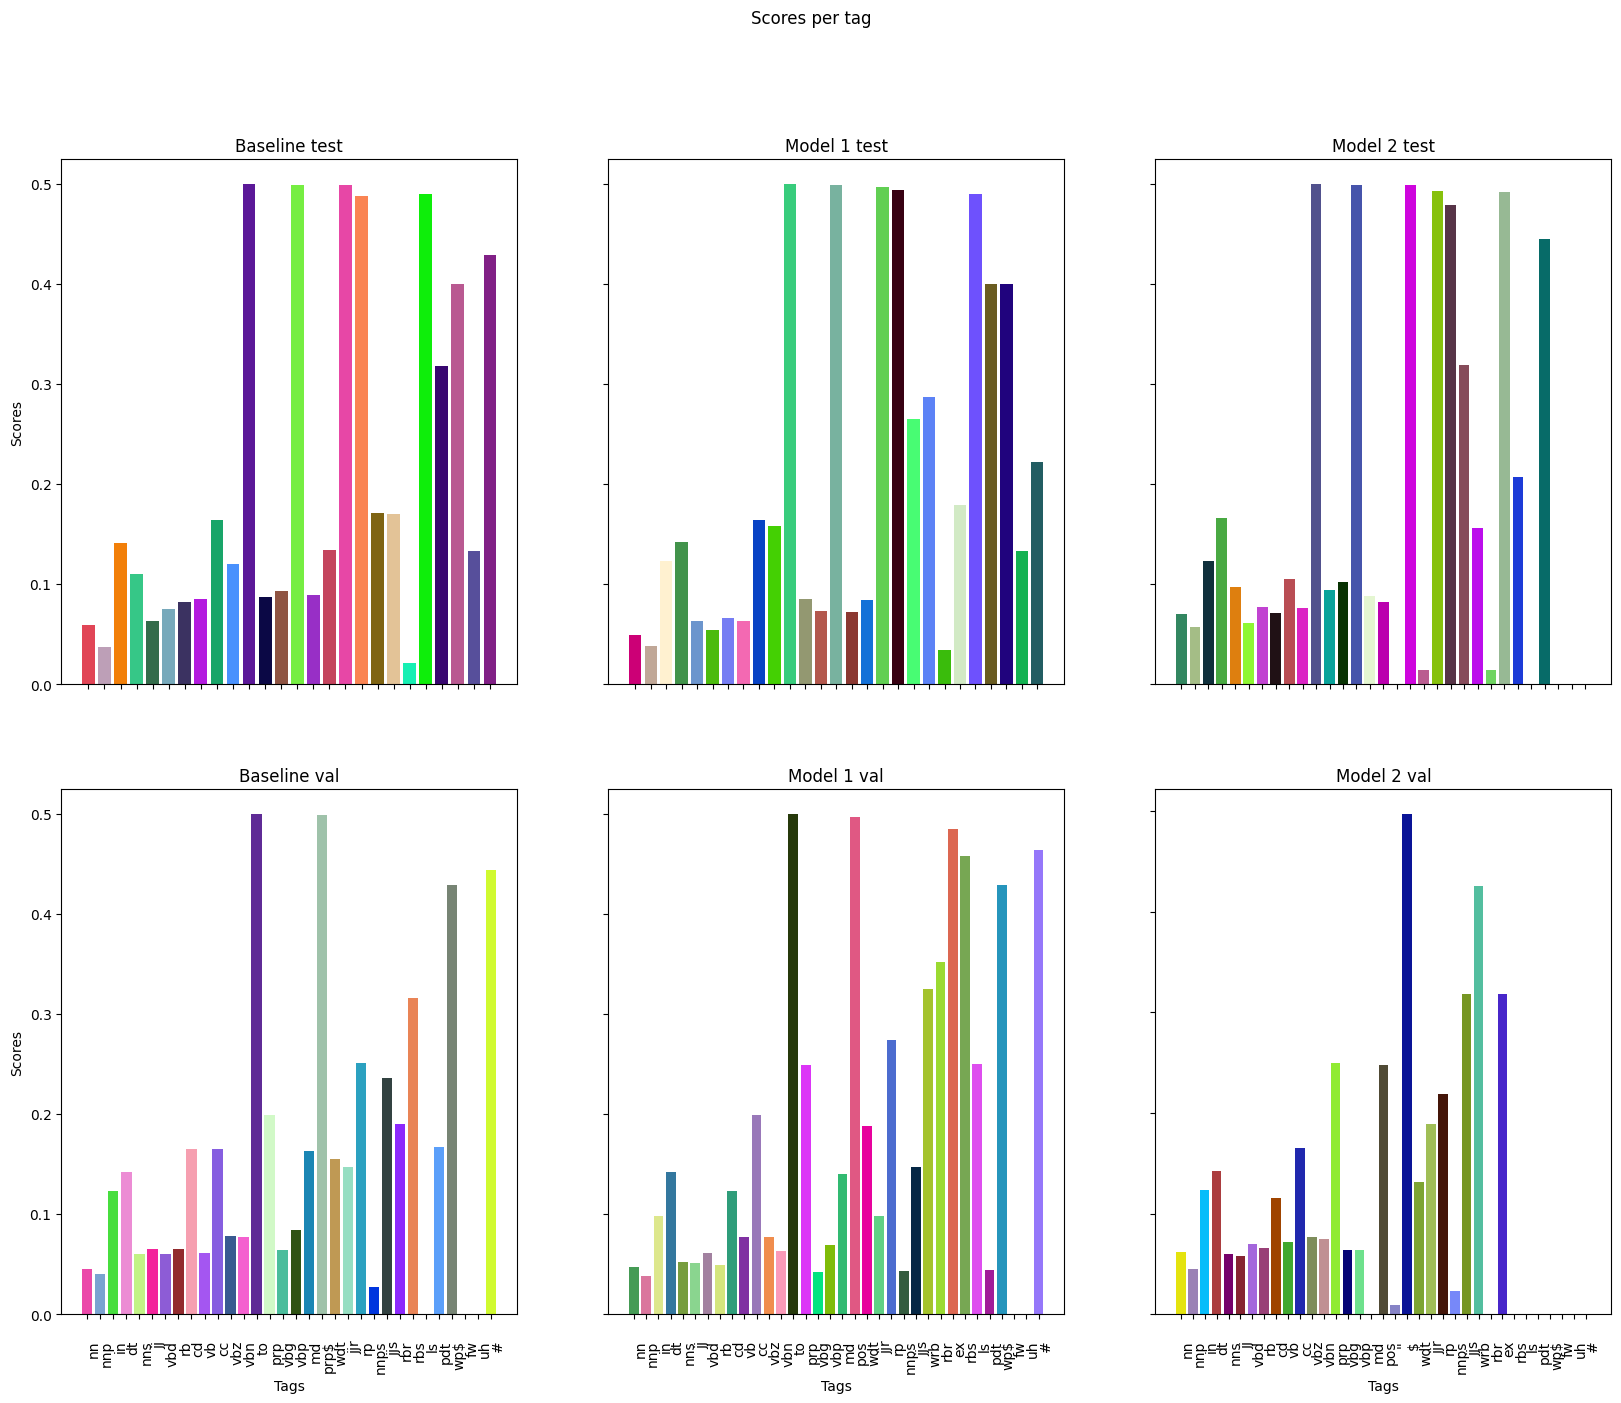

In [36]:
# Baseline model
baseline_test_pred = baseline.predict(X_test)
baseline_val_pred = baseline.predict(X_val)
scores_baseline_test = score_per_tag(Y_test, baseline_test_pred)
scores_baseline_test_tags = get_scores_tag(scores_baseline_test)
scores_baseline_val = score_per_tag(Y_val, baseline_val_pred)
scores_baseline_val_tags = get_scores_tag(scores_baseline_val)

# Model 1
model1_test_pred = model1.predict(X_test)
model1_val_pred = model1.predict(X_val)
scores_model1_test = score_per_tag(Y_test, model1_test_pred)
scores_model1_test_tags = get_scores_tag(scores_model1_test)
scores_model1_val = score_per_tag(Y_val, model1_val_pred)
scores_model1_val_tags = get_scores_tag(scores_model1_val)

# Model 2
model2_test_pred = model2.predict(X_test)
model2_val_pred = model2.predict(X_val)
scores_model2_test = score_per_tag(Y_test, model2_test_pred)
scores_model2_test_tags = get_scores_tag(scores_model2_test)
scores_model2_val = score_per_tag(Y_val, model2_val_pred)
scores_model2_val_tags = get_scores_tag(scores_model2_val)

# plot in a multifigure plot the scores of the models divided by test and validation
fig, axs = plt.subplots(2, 3, figsize=(20, 15))
fig.suptitle('Scores per tag')
# Baseline
axs[0, 0].bar(scores_baseline_test_tags.keys(), scores_baseline_test_tags.values(), color=set_color(len(scores_baseline_test_tags)))
axs[0, 0].set_title('Baseline test')
axs[1, 0].bar(scores_baseline_val_tags.keys(), scores_baseline_val_tags.values(), color=set_color(len(scores_baseline_val_tags)))
axs[1, 0].set_title('Baseline val')
# Model 1
axs[0, 1].bar(scores_model1_test_tags.keys(), scores_model1_test_tags.values(), color=set_color(len(scores_model1_test_tags)))
axs[0, 1].set_title('Model 1 test')
axs[1, 1].bar(scores_model1_val_tags.keys(), scores_model1_val_tags.values(), color=set_color(len(scores_model1_val_tags)))
axs[1, 1].set_title('Model 1 val')
# Model 2
axs[0, 2].bar(scores_model2_test_tags.keys(), scores_model2_test_tags.values(), color=set_color(len(scores_model2_test_tags)))
axs[0, 2].set_title('Model 2 test')
axs[1, 2].bar(scores_model2_val_tags.keys(), scores_model2_val_tags.values(), color=set_color(len(scores_model2_val_tags)))
axs[1, 2].set_title('Model 2 val')
for ax in axs.flat:
    ax.set(xlabel='Tags', ylabel='Scores')
    # Rotate tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=90, ha="right", rotation_mode="anchor")
    # Distance more x labels from each other
    ax.xaxis.set_tick_params(pad=15)
for ax in axs.flat:
    ax.label_outer()
plt.show()

Here we present the scores as a heatmap for model 1 on test and validation sets.

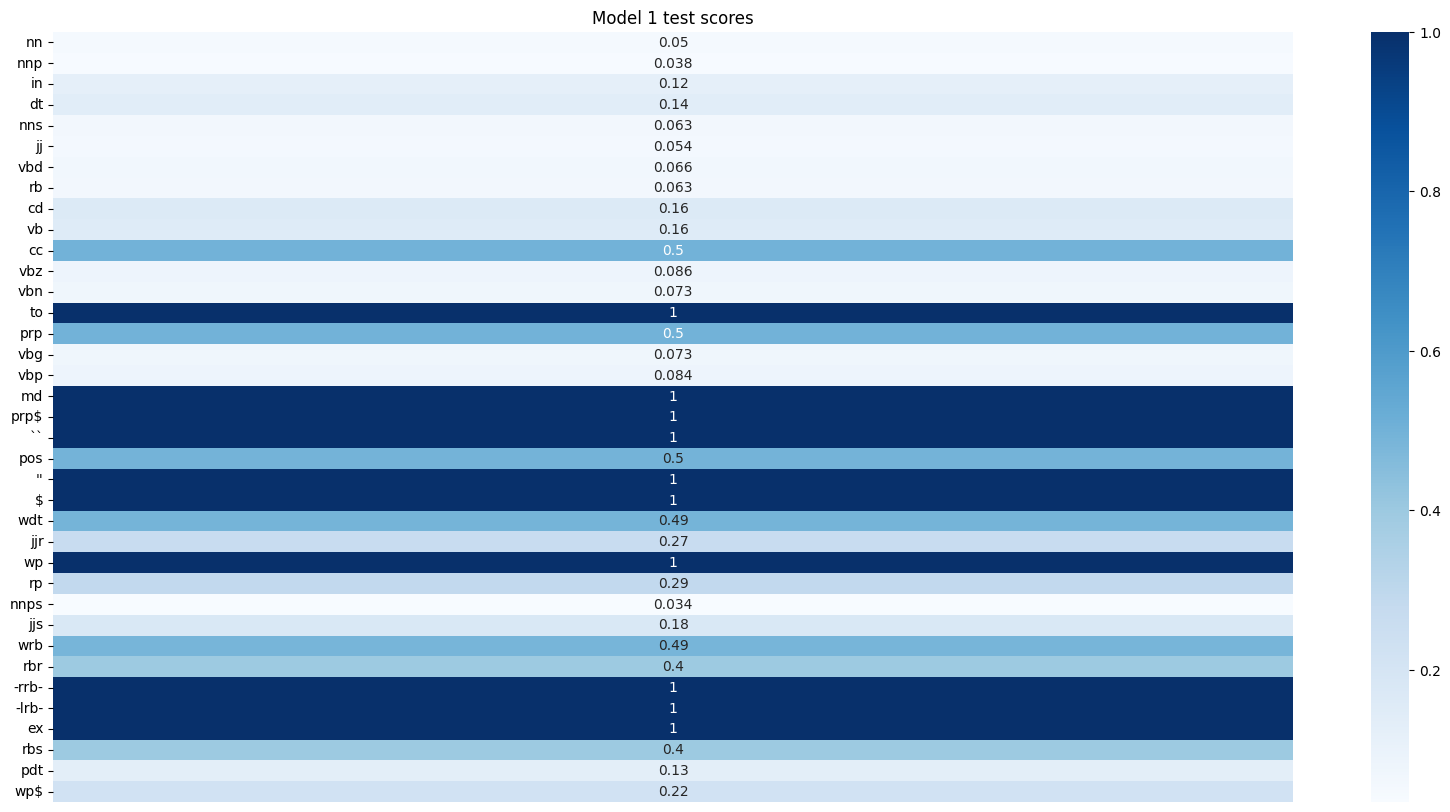

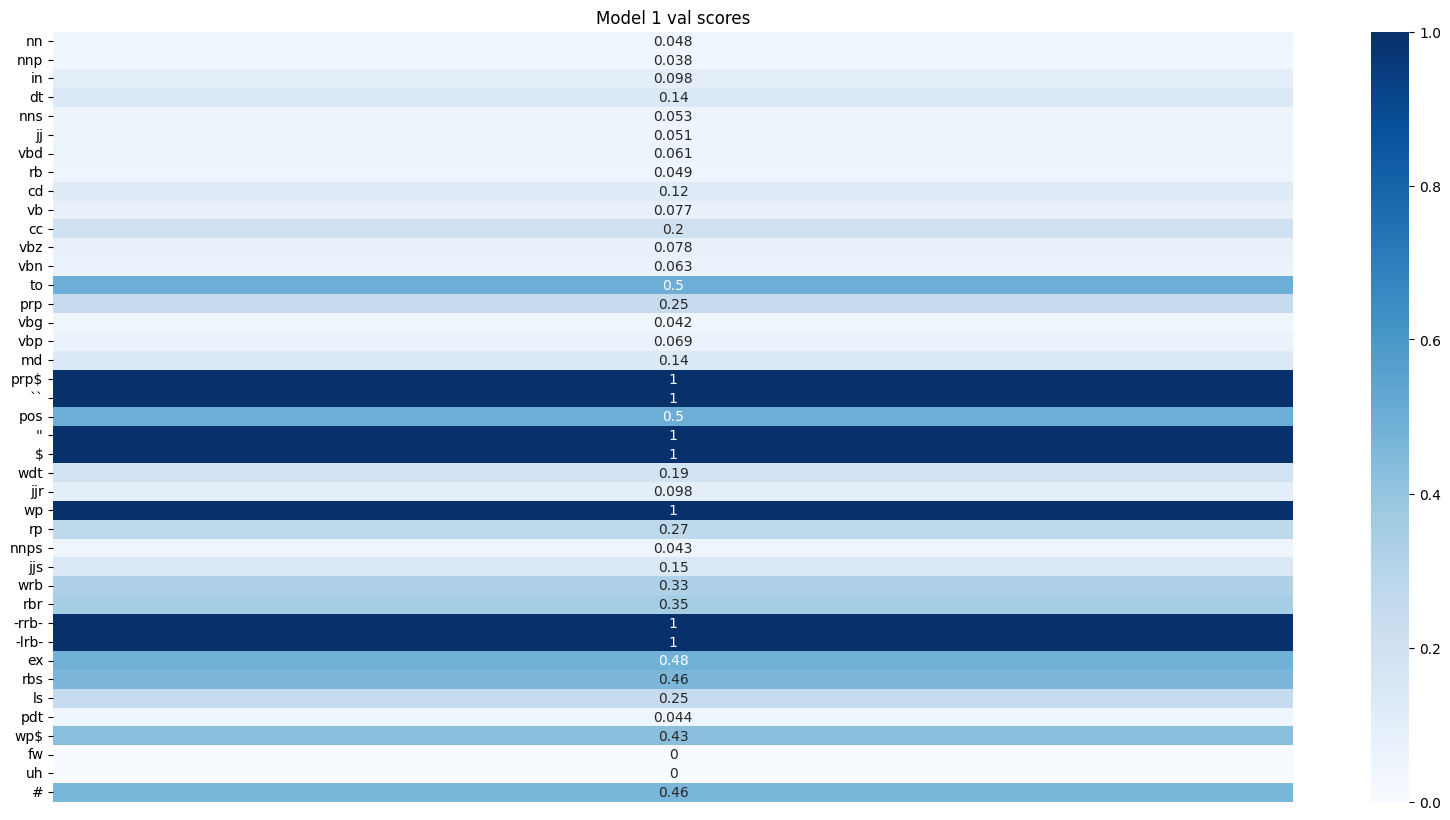

In [37]:
# heatmap of the scores of model 1 on test set and validation set

# Test set
plt.figure(figsize=(20, 10))
sns.heatmap(pd.DataFrame(scores_model1_test, index=[0]).T, annot=True, cmap='Blues')
plt.title('Model 1 test scores')
# hide x labels
plt.xticks([])
plt.show()

# Validation set
plt.figure(figsize=(20, 10))
sns.heatmap(pd.DataFrame(scores_model1_val, index=[0]).T, annot=True, cmap='Blues')
plt.title('Model 1 val scores')
# hide x labels
plt.xticks([])
plt.show()

In [38]:
# Most difficult tag for each model on test set
print("Most difficult tag for the baseline model on test set: {}".format(max(scores_baseline_test, key=scores_baseline_test.get)))
print("Most difficult tag for the model 1 on test set: {}".format(max(scores_model1_test, key=scores_model1_test.get)))
print("Most difficult tag for the model 2 on test set: {}".format(max(scores_model2_test, key=scores_model2_test.get)))

# Most difficult tag for each model on validation set
print("Most difficult tag for the baseline model on validation set: {}".format(max(scores_baseline_val, key=scores_baseline_val.get)))
print("Most difficult tag for the model 1 on validation set: {}".format(max(scores_model1_val, key=scores_model1_val.get)))
print("Most difficult tag for the model 2 on validation set: {}".format(max(scores_model2_val, key=scores_model2_val.get)))

Most difficult tag for the baseline model on test set: to
Most difficult tag for the model 1 on test set: to
Most difficult tag for the model 2 on test set: to
Most difficult tag for the baseline model on validation set: ``
Most difficult tag for the model 1 on validation set: prp$
Most difficult tag for the model 2 on validation set: to


As we can see all the models have difficulties with almost the same tags. This can be explained by the fact that the models are very similar and the hyperparameters are very similar as well, so overall they perform similarly (model 2 is worse than the other two but with more training it can be seen that it can rival baseline).

Another thing to note is that there are many words in the test and validation sets which are not in the GloVe embeddings. This is because we used the GloVe embeddings from the training set and the test and validation sets have words which are not present in the training set. This could be solved by using a larger GloVe embedding or by using a different embedding such as BERT or FastText.

Here we define the function to compute the confusion matrix. We use the sklearn confusion matrix function.

In [46]:
# Get confusion matrix for each model

def get_confusion_matrix(y_true, y_pred):
    y_true = np.argmax(y_true, axis=-1)
    y_pred = np.argmax(y_pred, axis=-1)
    y_true = y_true.flatten()
    y_pred = y_pred.flatten()
    temp = [] 
    temp_pred = []
    for i in range(len(y_true)):
        temp.append(y_true[i])
        temp_pred.append(y_pred[i])
    return confusion_matrix(temp, temp_pred)

We present the confusion matrix for the test and validation sets. We print only the confusion matrix for model 1 as it is the best performing model.

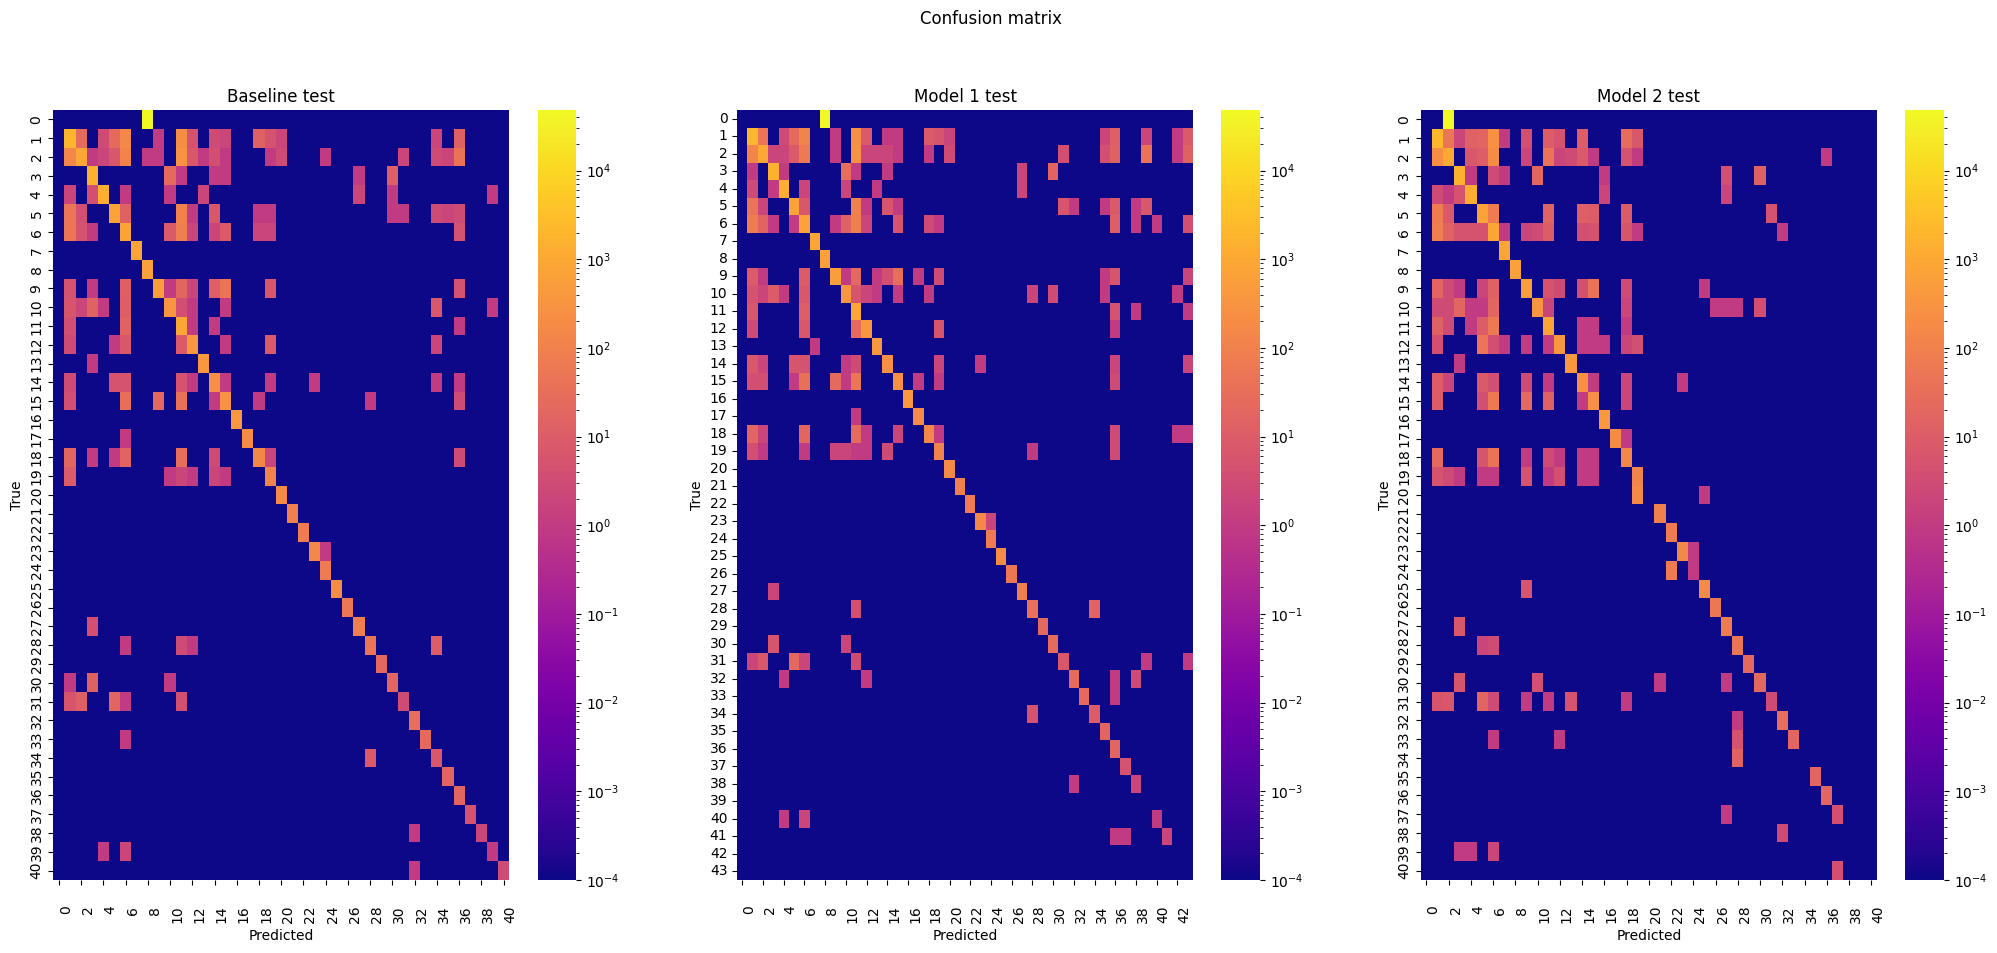

In [69]:
from matplotlib.colors import LogNorm
import math

# get confusion matrix for the baseline model
baseline_confusion_matrix_test = get_confusion_matrix(Y_test, baseline_test_pred)
baseline_confusion_matrix_val = get_confusion_matrix(Y_val, baseline_val_pred)
# add a small value to the confusion matrix to avoid log(0)
baseline_confusion_matrix_test = baseline_confusion_matrix_test + 0.0001

# get confusion matrix for model 1
model1_confusion_matrix_test = get_confusion_matrix(Y_test, model1_test_pred)
model1_confusion_matrix_val = get_confusion_matrix(Y_val, model1_val_pred)
# add a small value to the confusion matrix to avoid log(0)
model1_confusion_matrix_test = model1_confusion_matrix_test + 0.0001

# get confusion matrix for model 2
model2_confusion_matrix_test = get_confusion_matrix(Y_test, model2_test_pred)
model2_confusion_matrix_val = get_confusion_matrix(Y_val, model2_val_pred)
# add a small value to the confusion matrix to avoid log(0)
model2_confusion_matrix_test = model2_confusion_matrix_test + 0.0001

# plot confusion matrix for all models using a log scale
fig, axs = plt.subplots(1, 3, figsize=(25, 10))
fig.suptitle('Confusion matrix')
# Baseline
sns.heatmap(baseline_confusion_matrix_test, annot=False, cmap='plasma', norm=LogNorm(), ax=axs[0])
axs[0].set_title('Baseline test')
sns.heatmap(model1_confusion_matrix_test, annot=False, cmap='plasma', norm=LogNorm(), ax=axs[1])
axs[1].set_title('Model 1 test')
sns.heatmap(model2_confusion_matrix_test, annot=False, cmap='plasma', norm=LogNorm(), ax=axs[2])
axs[2].set_title('Model 2 test')
for ax in axs.flat:
    ax.set(xlabel='Predicted', ylabel='True')
    # Rotate tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=90, ha="right", rotation_mode="anchor")
    # Distance more x labels from each other
    ax.xaxis.set_tick_params(pad=15)
for ax in axs.flat:
    ax.label_outer()
plt.show()


Here in the confusion matrix we can see that the model has difficulties with the same tags as before. We can also see that the model has difficulties with the punctuation tags as well as the OOV tags. This is because we did not consider them in the F1-score computation. One thing to note is the diagonal which is quite high, which means that the model is quite good at predicting the correct tags. 

The main missclassifications are between the following tags: 1-20 (0-19 but thats's the idx).

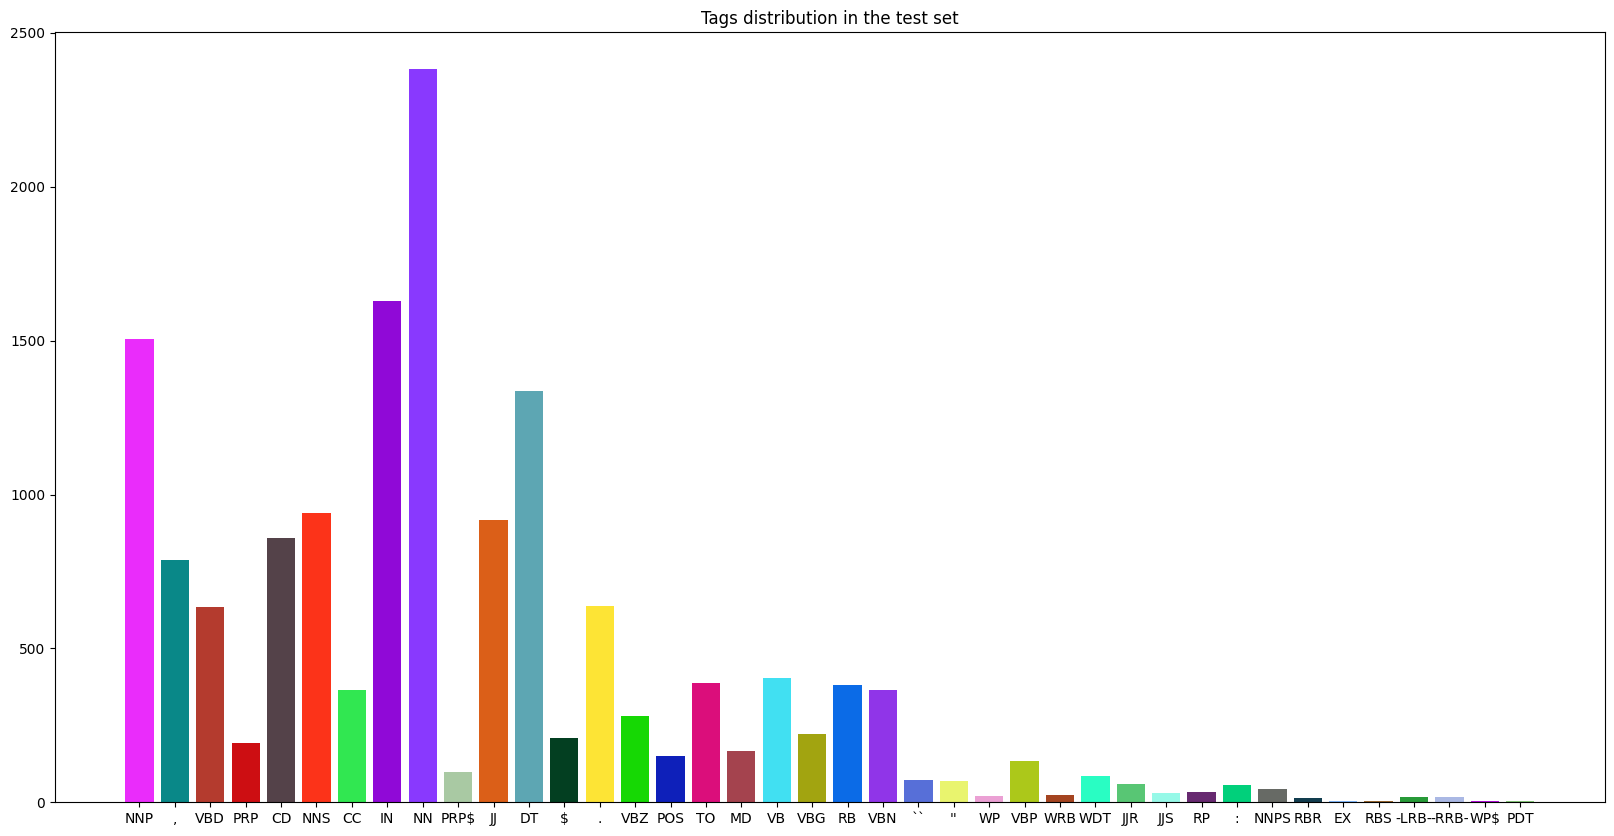

In [80]:
# count the number of times each tag appears in the test set
count_tags = Counter()
for sentence in test_tag_sentences:
    for tag in sentence:
        count_tags[tag] += 1

# plot tags distribution in the test set
plt.figure(figsize=(20, 10))
plt.bar(count_tags.keys(), count_tags.values(), color=set_color(len(count_tags)))
plt.title('Tags distribution in the test set')
plt.show()


This is also due to the fact that those are the most common tags in the dataset. One way to solve this could be to use a weighted loss function which would penalize more the missclassifications of the less common tags.

In [51]:
# get the most frequent tag from encoded tags

def get_most_least_frequent_tag(encoded_tags):
    temp = []
    for sentence in encoded_tags:
        for tag in sentence:
            if tag not in punctuation_tags_idx and tag != 0:
                temp.append(tag)
    # get the most frequent tag
    most_frequent_tag = Counter(temp).most_common(1)[0][0]
    print(f'Times the most frequent tag appears: {Counter(temp).most_common(1)[0][1]}')
    # get the least frequent tag
    least_frequent_tag = Counter(temp).most_common()[-1][0]
    print(f'Times the least frequent tag appears: {Counter(temp).most_common()[-1][1]}')
    return most_frequent_tag, least_frequent_tag

Here we analyze the errors made on the most and least frequent tags.

Model 1 on test set:
Times the most frequent tag appears: 2383
Times the least frequent tag appears: 3
Most frequent tag: nn
Least frequent tag: rbs
Model 1 performance on the most frequent tag: 0.07621650345403476
Model 1 performance on the least frequent tag: 1.0

Model 1 on validation set:
Times the most frequent tag appears: 4513
Times the least frequent tag appears: 2
Most frequent tag: nn
Least frequent tag: uh
Model 1 performance on the most frequent tag: 0.05759349982076711
Model 1 performance on the least frequent tag: 0.0


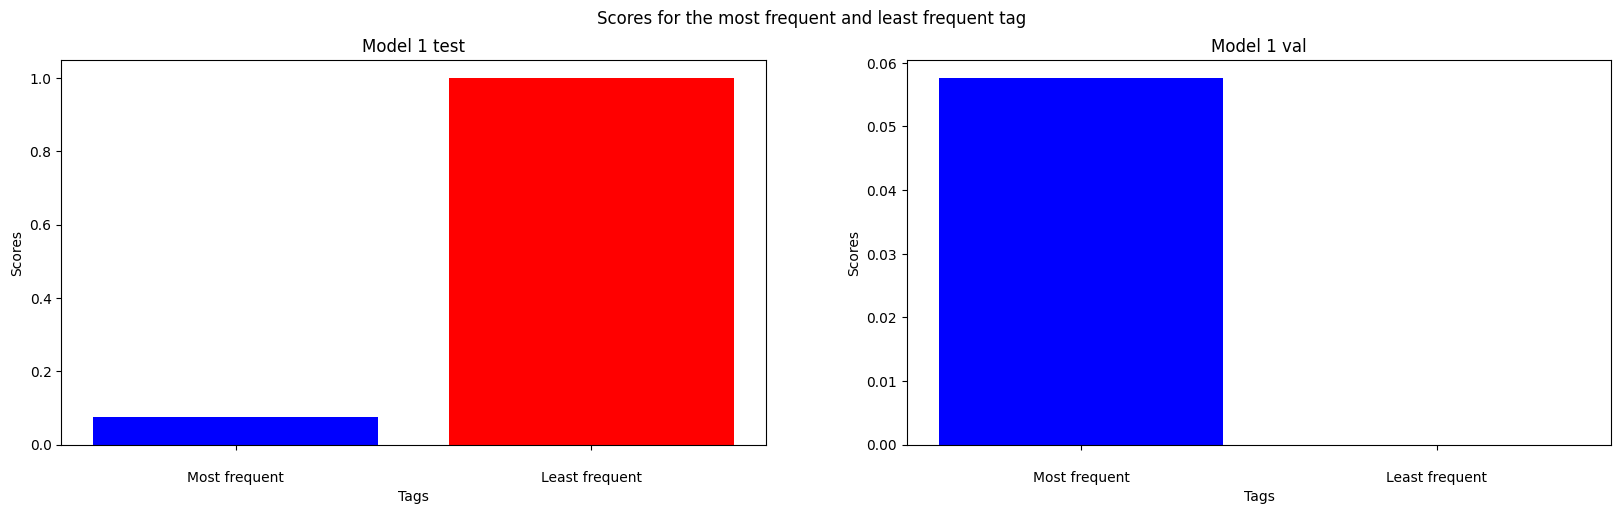

In [52]:
# Model 1 performance on the most frequent tag and the least frequent tag in test set
print("Model 1 on test set:")
most_frequent_tag_test, least_frequent_tag_test = get_most_least_frequent_tag(encoded_test_tags)
print("Most frequent tag: {}".format(idx2tag[most_frequent_tag_test]))
print("Least frequent tag: {}".format(idx2tag[least_frequent_tag_test]))
print("Model 1 performance on the most frequent tag: {}".format(scores_model1_test[idx2tag[most_frequent_tag_test]]))
print("Model 1 performance on the least frequent tag: {}".format(scores_model1_test[idx2tag[least_frequent_tag_test]]))

# Model 1 performance on the most frequent tag and the least frequent tag on validation set
print("\nModel 1 on validation set:")
most_frequent_tag_val, least_frequent_tag_val = get_most_least_frequent_tag(encoded_val_tags)
print("Most frequent tag: {}".format(idx2tag[most_frequent_tag_val]))
print("Least frequent tag: {}".format(idx2tag[least_frequent_tag_val]))
print("Model 1 performance on the most frequent tag: {}".format(scores_model1_val[idx2tag[most_frequent_tag_val]]))
print("Model 1 performance on the least frequent tag: {}".format(scores_model1_val[idx2tag[least_frequent_tag_val]]))

# plot scores for the most frequent and least frequent tag for each baseline on test set and validation set
fig, axs = plt.subplots(1, 2, figsize=(20, 5))
fig.suptitle('Scores for the most frequent and least frequent tag')
# Baseline
axs[0].bar(['Most frequent', 'Least frequent'], [scores_model1_test[idx2tag[most_frequent_tag_test]], scores_model1_test[idx2tag[least_frequent_tag_test]]], color=['#0000FF', '#FF0000'])
axs[0].set_title('Model 1 test')
axs[1].bar(['Most frequent', 'Least frequent'], [scores_model1_val[idx2tag[most_frequent_tag_val]], scores_model1_val[idx2tag[least_frequent_tag_val]]], color=['#0000FF', '#FF0000'])
axs[1].set_title('Model 1 val')
for ax in axs.flat:
    ax.set(xlabel='Tags', ylabel='Scores')
    # Distance more x labels from each other
    ax.xaxis.set_tick_params(pad=15)
plt.show()

Here we see that the even though "nn" is the most frequent tag it is not the one with the best score. This is because it is a very general tag and it is hard to predict correctly. The same can be said for the least frequent tag "uh". This tag is very rare and it is hard to predict correctly. Something to note is that for the tag "rbs" the model has a score of 1. This may be due to the fact that it is present in the test set only 3 times and it is correctly predicted each time, so we don't think it is a good indicator of the model's performance.

One solution would be to use a better split of the data, for example we could use a stratified split in order to have a more balanced distribution of the tags in the sets.

We plot the precision/recall curve for model 1 on the test set and validation set.

40/40 [==============================] - 5s 119ms/step


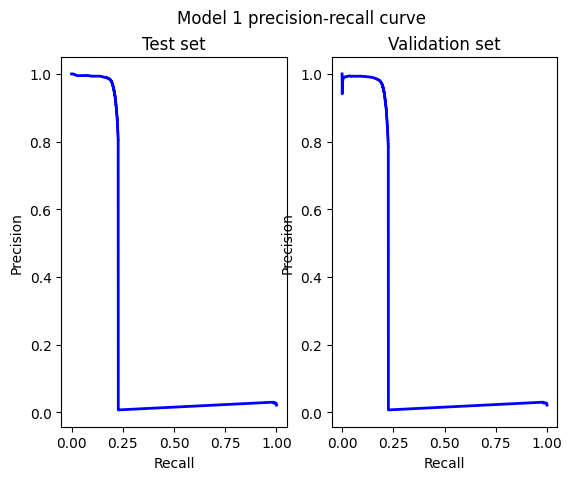

In [53]:
# Get precision/recall for the baseline model
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import precision_recall_curve

# plot precision-recall curve for the baseline model for test and validation set in a multifigure plot
fig, (ax1, ax2) = plt.subplots(1, 2)
fig.suptitle('Model 1 precision-recall curve')
# test set
precision_test = dict()
recall_test = dict()
precision_test["micro"], recall_test["micro"], _ = precision_recall_curve(Y_test.ravel(), model1.predict(X_test).ravel())
ax1.plot(recall_test["micro"], precision_test["micro"], color='blue', lw=2)
ax1.set_xlabel('Recall')
ax1.set_ylabel('Precision')
ax1.set_title('Test set')
# validation set
precision_val = dict()
recall_val = dict()
precision_val["micro"], recall_val["micro"], _ = precision_recall_curve(Y_val.ravel(), model1.predict(X_val).ravel())
ax2.plot(recall_val["micro"], precision_val["micro"], color='blue', lw=2)
ax2.set_xlabel('Recall')
ax2.set_ylabel('Precision')
ax2.set_title('Validation set')
plt.show()

For both the test set and validation set we see that the precision/recall curve is very similar. Initially the precision is very high but the recall is very low. This is because the model predicts very few tags but it predicts them correctly. As the recall increases the precision decreases. This is because the model starts to predict more tags but it also starts to make more mistakes. This is a common problem with POS tagging as the tags are very similar and it is hard to distinguish between them.

We analyze the errors made by model 1 on the test set.

In [54]:
# get specific missclassified samples for the model 1 

y_pred = model1.predict(X_test)
y_pred = np.argmax(y_pred, axis=-1)
y_pred = y_pred.flatten()
y_true = np.argmax(Y_test, axis=-1)
y_true = y_true.flatten()

temp = []
for i in range(len(encoded_test_sentences)):
    for elem in encoded_test_sentences[i]:
        temp.append(elem)
# get the index of the missclassified samples

missclassified_samples = []
for i in range(len(y_true)):
    if y_true[i] != y_pred[i]:
        if y_true[i] not in punctuation_tags_idx and y_true[i] != 0:
            missclassified_samples.append(i)
 
# create a table with the missclassified samples: word, true tag, predicted tag for the first 10 samples
sample_dict = {}
for i in range(10):
    sample_dict[i] = [sentence_tokenizer.sequences_to_texts([missclassified_samples[i:i+1]]), idx2tag[y_true[missclassified_samples[i]]], idx2tag[y_pred[missclassified_samples[i]]]]

# create a dataframe from the dictionary
df = pd.DataFrame.from_dict(sample_dict, orient='index', columns=['Word', 'True tag', 'Predicted tag'])
print(df)

20/20 [==============================] - 2s 120ms/step
         Word True tag Predicted tag
0     [corp.]       cd            jj
1         [i]       in            rb
2      [both]      nnp            nn
3  [interest]       cd            jj
4       [pay]      nns            jj
5     [firms]      nnp            jj
6   [comment]      vbn           vbd
7     [talks]      nnp            nn
8     [total]       vb            jj
9     [women]      nnp            jj


Here we can observe a specific error made by the model. The model predicts "nn" instead of "nnp" which indicates that it has difficulties with proper nouns. This may be due to them being very similar to nouns in the interpretation of the model. 

Another common  error is the assignement of the "jj" tag to almost all the words. This may be due to the fact that the model has a siginificant bias towards this tag. Our solution to this problem would be to use a more balanced dataset like we mentioned before as it would help the model learn the tags better and not have a bias towards a specific tag.

Here we present some sentences and their original tags and the predicted tags as a general overview of the model's performance.

In [55]:
# 5 sentences from the test set and print the true and predicted tags

for i in range(5):
    print(f'Sentence {i+1}')
    print(f'Original sentence: {test_sentences[i]}')
    print(f'True tags: {test_tag_sentences[i]}')
    # Remove padding from predicted tags 
    temp = []
    for tag in y_pred[i*MAX_SEQ_LENGTH:(i+1)*MAX_SEQ_LENGTH]:
        if tag != 9:
            temp.append(tag)
    print(f'Predicted tags: {[idx2tag[tag] for tag in temp]}')
    print('\n')


Sentence 1
Original sentence: ['Intelogic', 'Trace', 'Inc.', ',', 'San', 'Antonio', ',', 'Texas', ',', 'said', 'it', 'bought', '2.7', 'million', 'shares', ',', 'or', 'about', '18', '%', ',', 'of', 'its', 'common', 'stock', 'from', 'an', 'unaffiliated', 'shareholder', 'for', '$', '3.625', 'a', 'share', ',', 'or', '$', '9.9', 'million', '.']
True tags: ['NNP', 'NNP', 'NNP', ',', 'NNP', 'NNP', ',', 'NNP', ',', 'VBD', 'PRP', 'VBD', 'CD', 'CD', 'NNS', ',', 'CC', 'IN', 'CD', 'NN', ',', 'IN', 'PRP$', 'JJ', 'NN', 'IN', 'DT', 'JJ', 'NN', 'IN', '$', 'CD', 'DT', 'NN', ',', 'CC', '$', 'CD', 'CD', '.']
Predicted tags: ['nnp', 'nnp', 'nnp', ',', 'nnp', 'nnp', ',', 'nnp', ',', 'vbd', 'prp', 'vbd', 'jj', 'cd', 'nns', ',', 'cc', 'rb', 'cd', 'nn', ',', 'in', 'prp$', 'jj', 'nn', 'in', 'dt', 'jj', 'nn', 'in', '$', 'cd', 'dt', 'nn', ',', 'cc', '$', 'cd', 'cd']


Sentence 2
Original sentence: ['The', 'move', 'boosts', 'Intelogic', 'Chairman', 'Asher', 'Edelman', "'s", 'stake', 'to', '20', '%', 'from', '16.2